Paso 1: Carga y vista general de los datos principales

1.1 Código para cargar datos desde SQLite

In [35]:
import pandas as pd
import sqlite3
import numpy as np
# Conexión a la base de datos
conn = sqlite3.connect("instacart.db")

# Carga de tablas principales
orders = pd.read_sql("SELECT * FROM orders", conn)
order_products_prior = pd.read_sql("SELECT * FROM order_products_prior", conn)
products = pd.read_sql("SELECT * FROM products", conn)

# Cierre de conexión si no vas a usar más queries SQL
# conn.close()  # opcional si prefieres seguir con SQL


1.2 Estadísticas iniciales

In [36]:
# Números clave
print("🧑‍🛒 Número de usuarios únicos:", orders['user_id'].nunique())
print("📦 Número total de productos:", products['product_id'].nunique())
print("🧾 Número total de pedidos:", orders['order_id'].nunique())
print("📑 Número de líneas de pedidos en PRIOR:", order_products_prior.shape[0])

# Promedio de productos por pedido
avg_products_per_order = order_products_prior.groupby("order_id")["product_id"].count().mean()
print("📊 Promedio de productos por pedido:", round(avg_products_per_order, 2))


🧑‍🛒 Número de usuarios únicos: 206209
📦 Número total de productos: 49688
🧾 Número total de pedidos: 3421083
📑 Número de líneas de pedidos en PRIOR: 32434489
📊 Promedio de productos por pedido: 10.09


Paso 2: Análisis más profundo del dataset

2.1 Frecuencia de compra por producto

In [37]:
# Número total de veces que se ha comprado cada producto
product_counts = order_products_prior['product_id'].value_counts().reset_index()
product_counts.columns = ['product_id', 'num_times_ordered']

# Unimos con nombres de productos
product_stats = product_counts.merge(products[['product_id', 'product_name']], on='product_id')

# Mostramos los 10 productos más comprados
print("🛍️ Productos más comprados:")
display(product_stats.head(10))


🛍️ Productos más comprados:


,product_id,num_times_ordered,product_name
0,24852,472565,Banana
1,13176,379450,Bag of Organic Bananas
2,21137,264683,Organic Strawberries
3,21903,241921,Organic Baby Spinach
4,47209,213584,Organic Hass Avocado
5,47766,176815,Organic Avocado
6,47626,152657,Large Lemon
7,16797,142951,Strawberries
8,26209,140627,Limes
9,27845,137905,Organic Whole Milk


2.2 Actividad de los usuarios

📦 Promedio de pedidos por usuario: 16.59
📦 Máximo de pedidos por usuario: 100
📦 Mínimo de pedidos por usuario: 4


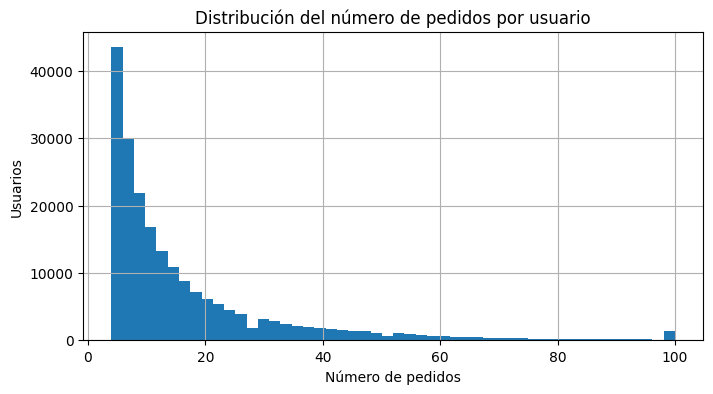

In [38]:
# Número de pedidos por usuario
user_order_counts = orders.groupby('user_id')['order_id'].count()
print("📦 Promedio de pedidos por usuario:", round(user_order_counts.mean(), 2))
print("📦 Máximo de pedidos por usuario:", user_order_counts.max())
print("📦 Mínimo de pedidos por usuario:", user_order_counts.min())

# Distribución de pedidos por usuario (opcional para gráfica)
import matplotlib.pyplot as plt

user_order_counts.hist(bins=50, figsize=(8, 4))
plt.title("Distribución del número de pedidos por usuario")
plt.xlabel("Número de pedidos")
plt.ylabel("Usuarios")
plt.show()


2.3 Revisión de nulos y duplicados



In [39]:
# Nulos
print("🧼 Nulos en ORDERS:")
print(orders.isnull().sum())

print("\n🧼 Nulos en ORDER_PRODUCTS_PRIOR:")
print(order_products_prior.isnull().sum())

print("\n🧼 Nulos en PRODUCTS:")
print(products.isnull().sum())

# Duplicados
print("\n🔁 Duplicados en ORDER_PRODUCTS_PRIOR:", order_products_prior.duplicated().sum())
print("🔁 Duplicados en ORDERS:", orders.duplicated().sum())
print("🔁 Duplicados en PRODUCTS:", products.duplicated().sum())


🧼 Nulos en ORDERS:
order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

🧼 Nulos en ORDER_PRODUCTS_PRIOR:
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

🧼 Nulos en PRODUCTS:
product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

🔁 Duplicados en ORDER_PRODUCTS_PRIOR: 0
🔁 Duplicados en ORDERS: 0
🔁 Duplicados en PRODUCTS: 0


2.4 Productos que nunca se han comprado

In [40]:
# Comprobamos productos no usados en prior
productos_comprados = set(order_products_prior['product_id'])
todos_los_productos = set(products['product_id'])
productos_nunca_comprados = todos_los_productos - productos_comprados

print("❌ Número de productos que nunca se han comprado:", len(productos_nunca_comprados))


❌ Número de productos que nunca se han comprado: 11


Limpieza de nulls

In [41]:
# Copia del dataframe
orders_cleaned = orders.copy()

# Usuarios con NaN y también con 0 en days_since_prior_order
nan_and_zero_users = orders_cleaned.groupby('user_id')['days_since_prior_order'].apply(
    lambda x: x.isnull().any() and (x == 0).any()
).pipe(lambda s: s[s].index)

# Eliminar solo los registros NaN de esos usuarios
mask = (orders_cleaned['user_id'].isin(nan_and_zero_users)) & (orders_cleaned['days_since_prior_order'].isnull())
orders_cleaned = orders_cleaned[~mask]

# Para el resto, rellenamos los NaN con 0
orders_cleaned['days_since_prior_order'] = orders_cleaned['days_since_prior_order'].fillna(0)


Paso 3: Filtrar productos nunca comprados

In [42]:
# Filtramos el dataframe de productos
products = products[products['product_id'].isin(productos_comprados)].reset_index(drop=True)

print("✅ Nuevo número de productos tras filtrar:", products.shape[0])


✅ Nuevo número de productos tras filtrar: 49677


Paso 4: Crear la matriz usuario-producto para SVD

In [ ]:
# Creamos el "rating" como el número de veces que un usuario ha comprado un producto
user_product_ratings = order_products_prior.merge(orders[['order_id', 'user_id']], on='order_id')

user_product_matrix = user_product_ratings.groupby(['user_id', 'product_id']).size().reset_index(name='rating')
df = user_product_matrix.copy()

print("🎯 Vista previa de la matriz usuario-producto:")
display(user_product_matrix.head())


🎯 Vista previa de la matriz usuario-producto:


,user_id,product_id,rating
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [ ]:
# -------------------------------
# Limpieza y preparación de datos
# -------------------------------

# Filtrar usuarios con pocas compras
min_ratings_user = 5
user_counts = df['user_id'].value_counts()
df = df[df['user_id'].isin(user_counts[user_counts >= min_ratings_user].index)]

# Filtrar productos con pocas compras
min_ratings_product = 5
product_counts = df['product_id'].value_counts()
df = df[df['product_id'].isin(product_counts[product_counts >= min_ratings_product].index)]

# (Opcional) Normalizar rating por usuario
# df['rating'] = df.groupby('user_id')['rating'].transform(lambda x: x / x.max())

# (Opcional) Transformación logarítmica suave
# df['rating'] = np.log1p(df['rating'])

# (Opcional) Limitar ratings muy altos para evitar outliers
# df['rating'] = df['rating'].clip(upper=10)

# Eliminar duplicados
df.drop_duplicates(subset=['user_id', 'product_id'], keep='last', inplace=True)


Paso 5: Entrenar un modelo SVD con Surprise


5.2 Preparar los datos para Surprise

In [44]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

# Creamos el lector de datos
reader = Reader(rating_scale=(1, user_product_matrix['rating'].max()))

# Dataset en formato Surprise
data = Dataset.load_from_df(user_product_matrix[['user_id', 'product_id', 'rating']], reader)

# División en train/test
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)


5.3 Entrenamiento del modelo SVD

In [45]:
# Modelo SVD
model = SVD()

# Entrenamos
model.fit(trainset)

# Predicción en test
predictions = model.test(testset)

# Métricas
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)


RMSE: 3.4571
MAE:  1.7628


In [46]:
# from surprise.model_selection import GridSearchCV

# param_grid = {
#     'n_factors': [50, 100],
#     'n_epochs': [20, 30],
#     'lr_all': [0.002, 0.005],
#     'reg_all': [0.02, 0.1]
# }

# gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
# gs.fit(data)

# print(gs.best_score['rmse'])
# print(gs.best_params['rmse'])


In [47]:
# model = SVD(**gs.best_params['rmse'])  # o SVD() si no usas GridSearch
# model.fit(trainset)


In [56]:
from surprise import SVD

model = SVD(
    n_factors=100,
    n_epochs=30,
    lr_all=0.005,
    reg_all=0.02
)
model.fit(trainset)


In [57]:
import joblib

# Guardar el modelo entrenado
joblib.dump(model, "svd_instacart_model.pkl")


['svd_instacart_model.pkl']

In [58]:
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)


RMSE: 3.4942
MAE:  1.7927


In [59]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Umbral para considerar una recomendación relevante
threshold = 4

# Convertimos predicciones a 1 (relevante) o 0 (no relevante)
y_true = [1 if true_r >= threshold else 0 for (_, _, true_r, _, _) in predictions]
y_pred = [1 if est >= threshold else 0 for (_, _, _, est, _) in predictions]

# Métricas binarizadas
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Precision: 0.3654
Recall: 0.3417
F1-score: 0.3532


5.4 Predicción para un usuario y producto concretos

In [52]:
# Predicción: ¿cuánto le gustará el producto 1234 al usuario 567?
uid = 567
iid = 1234
pred = model.predict(uid, iid)
print(f"Predicción de rating para user {uid}, producto {iid}: {pred.est}")


Predicción de rating para user 567, producto 1234: 99


In [53]:
def get_user_recommendations(user_id, model, user_product_matrix, products_df, top_n=10):
    # Productos ya comprados por el usuario
    productos_comprados = user_product_matrix[user_product_matrix['user_id'] == user_id]['product_id'].tolist()

    # Todos los productos posibles
    todos_productos = products_df['product_id'].unique()

    # Productos no comprados
    productos_a_predecir = [pid for pid in todos_productos if pid not in productos_comprados]

    # Predecimos el "rating" para cada uno de esos productos
    predicciones = [model.predict(user_id, pid) for pid in productos_a_predecir]

    # Ordenamos por mayor puntuación estimada
    predicciones.sort(key=lambda x: x.est, reverse=True)

    # Tomamos los top_n
    top_preds = predicciones[:top_n]

    # Juntamos con el nombre del producto
    recomendaciones = pd.DataFrame([{
        'product_id': pred.iid,
        'predicted_rating': pred.est
    } for pred in top_preds])

    recomendaciones = recomendaciones.merge(products_df[['product_id', 'product_name']], on='product_id')

    return recomendaciones


In [54]:
# Cambia este número por un user_id real de tu dataset
user_id_ejemplo = user_product_matrix['user_id'].sample(1).values[0]

recomendaciones = get_user_recommendations(user_id_ejemplo, model, user_product_matrix, products, top_n=10)
print(f"🔮 Recomendaciones para el usuario {user_id_ejemplo}:")
display(recomendaciones)


🔮 Recomendaciones para el usuario 194666:


,product_id,predicted_rating,product_name
0,1,99,Chocolate Sandwich Cookies
1,2,99,All-Seasons Salt
2,3,99,Robust Golden Unsweetened Oolong Tea
3,4,99,Smart Ones Classic Favorites Mini Rigatoni Wit...
4,5,99,Green Chile Anytime Sauce
5,6,99,Dry Nose Oil
6,7,99,Pure Coconut Water With Orange
7,8,99,Cut Russet Potatoes Steam N' Mash
8,9,99,Light Strawberry Blueberry Yogurt
9,10,99,Sparkling Orange Juice & Prickly Pear Beverage


In [55]:
from collections import defaultdict
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

# Umbral de relevancia
threshold = 4.0
top_k = 10

# Suponiendo que ya tienes estas predicciones hechas con el modelo entrenado SIN logaritmo:
# predictions = model.test(testset)

# --------------------------
# Obtener Top-N por usuario
# --------------------------
def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est, true_r))
    
    # Ordenar y quedarnos con los n mejores
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    
    return top_n

top_n = get_top_n(predictions, n=top_k)

# --------------------------
# Métrica: Hit Rate
# --------------------------
def hit_rate(top_n, threshold=4.0):
    hits = 0
    total = 0
    for uid, user_ratings in top_n.items():
        for _, _, true_r in user_ratings:
            if true_r >= threshold:
                hits += 1
            total += 1
    return hits / total if total > 0 else 0

# --------------------------
# Métrica: Recall@N
# --------------------------
def recall_at_n(top_n, all_predictions, n=10, threshold=4.0):
    relevant_per_user = defaultdict(set)
    for uid, iid, true_r, est, _ in all_predictions:
        if true_r >= threshold:
            relevant_per_user[uid].add(iid)
    
    hits = 0
    total_relevant = 0
    for uid, user_ratings in top_n.items():
        predicted_iids = [iid for iid, _, _ in user_ratings]
        hits += len(set(predicted_iids) & relevant_per_user[uid])
        total_relevant += len(relevant_per_user[uid])
    
    return hits / total_relevant if total_relevant > 0 else 0

# --------------------------
# Resultados
# --------------------------
hitrate = hit_rate(top_n, threshold=threshold)
recalln = recall_at_n(top_n, predictions, n=top_k, threshold=threshold)

print(f"Hit Rate: {hitrate:.4f}")
print(f"Recall@{top_k}: {recalln:.4f}")



Hit Rate: 0.1350
Recall@10: 0.4912
